In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="oSQ3W2NV98ysGvMr3Rpk")
project = rf.workspace().project("efficientnet_character_classification")
dataset = project.version(3).download("folder")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to efficientnet_character_classification-3 in folder:: 100%|██████████| 1227/1227 [00:01<00:00, 1115.88it/s]


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path="/content/efficientnet_character_classification-3/train"
test_path="/content/efficientnet_character_classification-3/test"
val_path="/content/efficientnet_character_classification-3/valid"

In [ ]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)
    

x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)
    

train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x.shape,test_x.shape,val_x.shape

((970, 224, 224, 3), (120, 224, 224, 3), (120, 224, 224, 3))

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 970 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
training_set.class_indices

{'arjun': 0, 'bheem': 1, 'karan': 2, 'krish': 3}

In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes
train_y.shape,test_y.shape,val_y.shape

((970,), (120,), (120,))

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)

#Early stopping to avoid overfitting of model

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=20,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/20
31/31 [==============================] - 27s 395ms/step - loss: 1.1663 - accuracy: 0.5649 - val_loss: 1.0337 - val_accuracy: 0.6833
Epoch 2/20
31/31 [==============================] - 5s 164ms/step - loss: 0.3851 - accuracy: 0.8649 - val_loss: 0.8731 - val_accuracy: 0.7167
Epoch 3/20
31/31 [==============================] - 5s 166ms/step - loss: 0.2052 - accuracy: 0.9412 - val_loss: 0.7789 - val_accuracy: 0.7083
Epoch 4/20
31/31 [==============================] - 5s 169ms/step - loss: 0.1038 - accuracy: 0.9866 - val_loss: 0.7992 - val_accuracy: 0.7250
Epoch 5/20
31/31 [==============================] - 5s 170ms/step - loss: 0.0645 - accuracy: 0.9990 - val_loss: 0.8116 - val_accuracy: 0.7500
Epoch 6/20
31/31 [==============================] - 5s 172ms/step - loss: 0.0437 - accuracy: 1.0000 - val_loss: 0.8021 - val_accuracy: 0.7083
Epoch 7/20
31/31 [==============================] - 5s 173ms/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.8195 - val_accuracy: 0.7500
Epoch

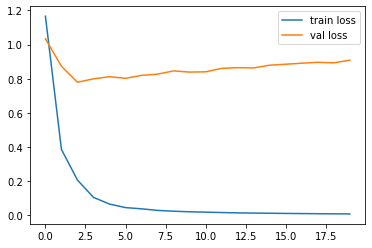

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

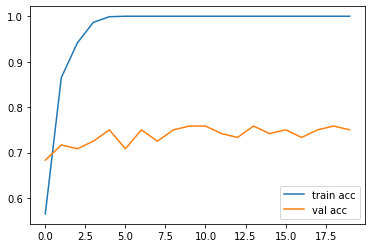

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [ ]:
model.evaluate(test_x,test_y,batch_size=32)

4/4 [==============================] - 1s 154ms/step - loss: 0.8620 - accuracy: 0.7667


[0.8619565367698669, 0.7666666507720947]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

accuracy_score(y_pred,test_y)

0.7666666666666667

In [ ]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.78      0.84      0.81        25
           2       0.70      0.78      0.74        27
           3       0.71      0.69      0.70        35

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120



In [ ]:
confusion_matrix(y_pred,test_y)

array([[26,  2,  2,  3],
       [ 0, 21,  3,  1],
       [ 0,  0, 21,  6],
       [ 3,  4,  4, 24]])

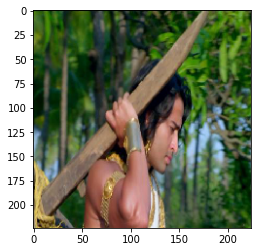

arjun


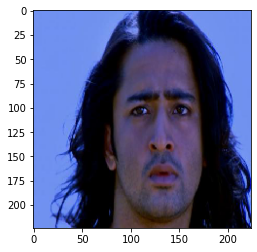

bheem


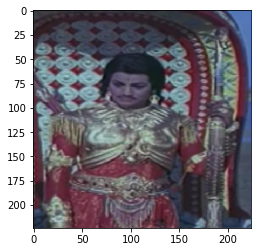

arjun


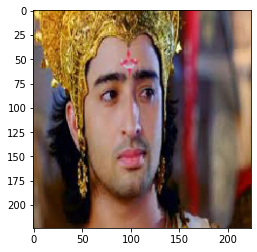

karan


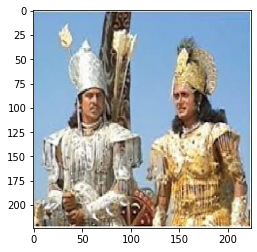

arjun


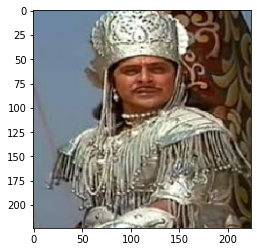

karan


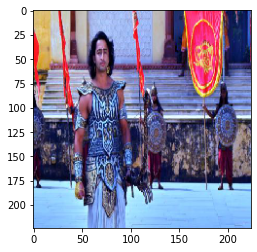

arjun


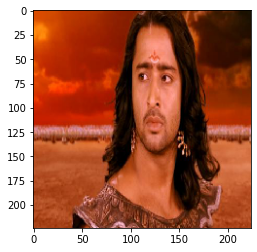

arjun


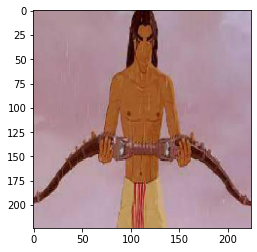

karan


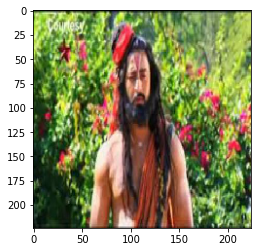

arjun


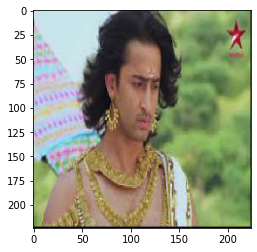

karan


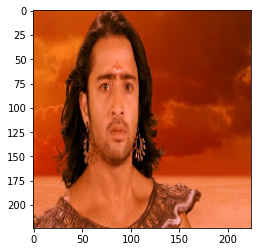

karan


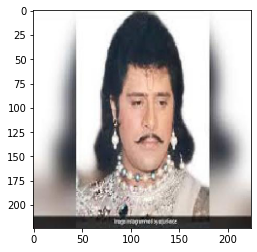

arjun


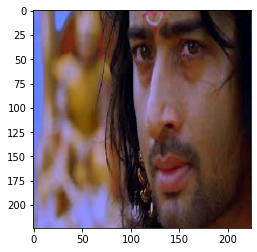

karan


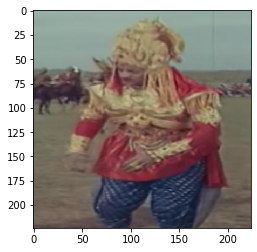

karan


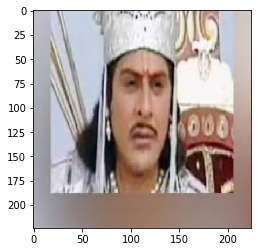

karan


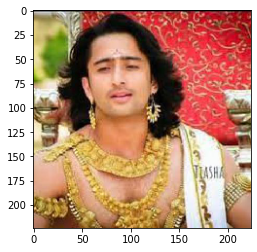

karan


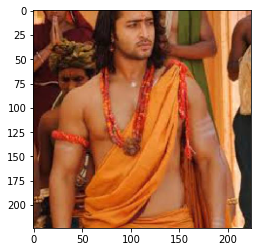

arjun


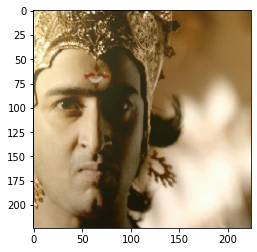

karan


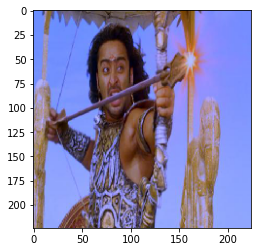

arjun


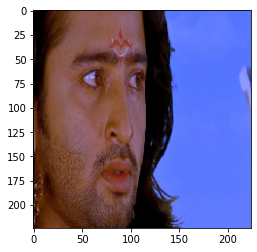

karan


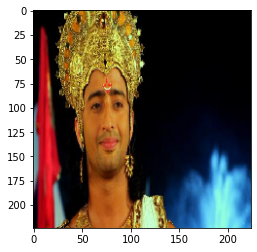

karan


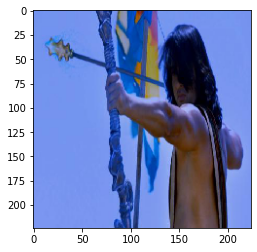

arjun


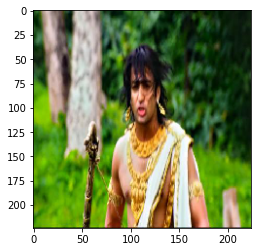

arjun


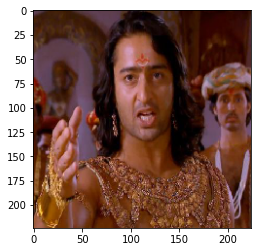

arjun


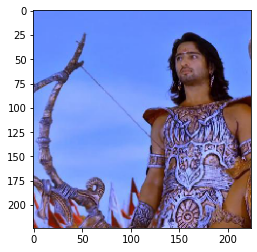

arjun


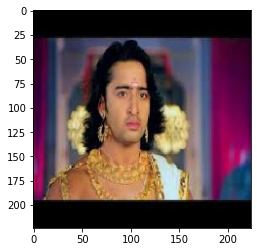

bheem


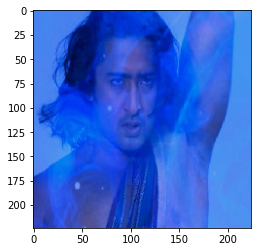

arjun


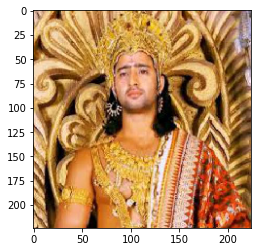

karan


In [ ]:
path="/content/efficientnet_character_classification-3/test/arjun"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    if pred[0][0]>0.5:
        print("arjun")
    elif pred[0][1]>0.5:
        print("bheem")
    elif pred[0][2]>0.5:
        print("karan")
    elif pred[0][3]>0.5:
        print("krish")
    else:
      print("Unknown")

